Using baseline

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import h5py
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nitorch.data import load_nifti
from nitorch.transforms import ToTensor
from pif import PatchIndividualFilters3D

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Parameters

In [5]:
gpu = 1
model_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/full_set/baseline/"
model_path = os.path.join(model_dir,"repeat_0_cv_fold_0_BEST_ITERATION.h5")

### Model definition

In [6]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_5 = nn.Conv3d(64, 36, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        
        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            #nn.Dropout(0.6),
            nn.Linear(1296, 80),
            #nn.Dropout(0.6),
            nn.Linear(80, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if print_size:
            print(h.shape)
        
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [7]:
# load pre-trained weights
net = SixtyFourNet()
net.load_state_dict(torch.load(model_path))
net = net.cuda(gpu)
net.eval()

SixtyFourNet(
  (dropout): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_5): Conv3d(64, 36, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier_scratch): Sequential(
    (0): Linear(in_features=1296, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=1, bias=True)
  )
)

In [8]:
neuron = list(dict(net.named_children())["Conv_1"].parameters())[0][0]

# Generate feature visualization through optimization

### Create starting point

In [9]:
base = torch.rand((1, 96, 114, 96))

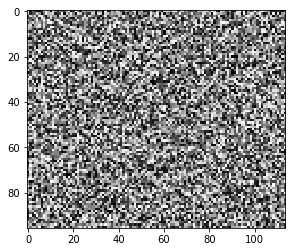

In [10]:
plt.imshow(base[0,:,:,48], cmap='gray')

In [11]:
start, end = 32, 32+5

In [12]:
val_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
X, y = val_h5['X'][start:end], val_h5['y'][start:end]
del val_h5

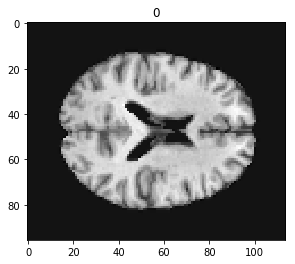

In [13]:
plt.imshow(X[0,:,:,48], cmap='gray')
plt.title(y[0])
plt.show()

In [14]:
for i, img in enumerate(X):
    X[i] = img / np.max(img) # normalize
X = torch.Tensor(X)

In [15]:
n_filters = 5

In [16]:
activation = None
class SaveActivation():
    def __init__(self, n_filters):
        self.activation = []
        self.n_filters = n_filters

    def __call__(self, module, input, output):
        print(output.data.shape)
        print(len(output.data) * self.n_filters)
        for i in range(len(output.data)):
            for j in range(self.n_filters):
                self.activation.append(output.data[i, j])
        
    def get_activation(self):
        return self.activation

In [17]:
saver = SaveActivation(n_filters)
len(saver.get_activation())

0

In [18]:
hook = net.Conv_4.register_forward_hook(saver)

In [19]:
net.forward(torch.unsqueeze(X, 1).cuda(gpu))

torch.Size([5, 64, 10, 13, 10])
25


tensor([[-2.2942],
        [-2.3327],
        [ 1.3802],
        [ 5.5677],
        [ 5.3139]], device='cuda:1', grad_fn=<AddmmBackward>)

In [20]:
len(saver.get_activation())

25

In [21]:
saver.n_filters

5

In [22]:
activation_shape = saver.get_activation()[0].shape
n_imgs = len(X)

activations = np.zeros(shape=(n_filters, )+tuple(activation_shape))
print(np.shape(activations))

for i in range(n_imgs):
    print("Next")
    for j in range(n_filters):
        activation = saver.get_activation()[(i*n_filters)+j].cpu().numpy()
        #plt.imshow(activation[:,:,5], cmap='gray')  
        #plt.show()
        activations[j] += activation

(5, 10, 13, 10)
Next
Next
Next
Next
Next


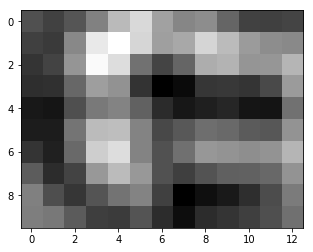

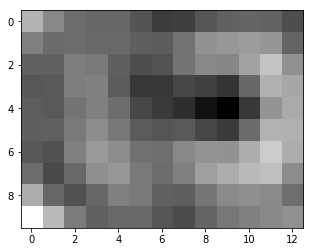

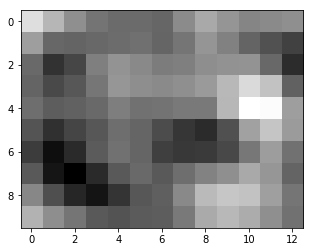

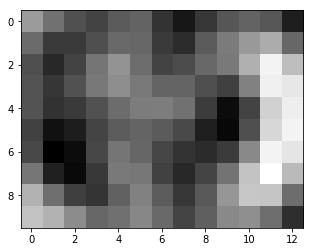

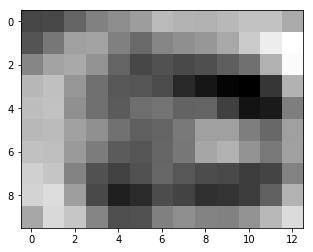

In [23]:
for activation in activations:
    plt.imshow(activation[:,:,5]/n_filters, cmap='gray')
    plt.show()

Backpropagate from feature map

In [24]:
std = torch.Tensor([0.05, 0.05, 0.05, 0.05]).repeat(4,4,1).unsqueeze(0)
gaussian_kernel = torch.normal(mean=1, std=std).unsqueeze(0)

In [25]:
gaussian_kernel.shape

torch.Size([1, 1, 4, 4, 4])

In [53]:
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_5 = nn.Conv3d(64, 36, kernel_size=3, stride=1, padding=0)

        self.blur = blur_kernel

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))        
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1)
        x = self.encode(x, print_size=print_size)
        #x = self.flatten(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [54]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

In [55]:
new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
Conv_4.weight
Conv_4.bias
Conv_5.weight
Conv_5.bias


In [56]:
sub_model.load_state_dict(new_state_dict)

In [57]:
sub_model.cuda(gpu)
sub_model.eval()

SubModel(
  (dropout): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_5): Conv3d(64, 36, kernel_size=(3, 3, 3), stride=(1, 1, 1))
)

In [58]:
X = X.requires_grad_()

In [59]:
sub_model.zero_grad()

In [60]:
res = sub_model.forward(torch.unsqueeze(X, 1).cuda(gpu))

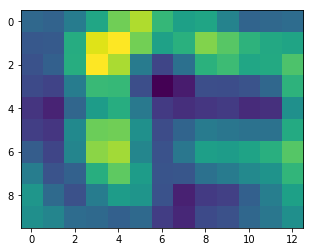

In [61]:
plt.imshow(saver.get_activation()[5].cpu().numpy()[:,:,5])
plt.show()

In [62]:
res_img = res[1].cpu().detach().numpy()

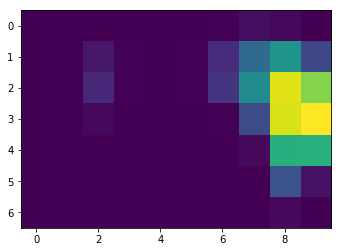

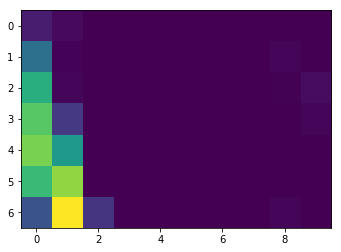

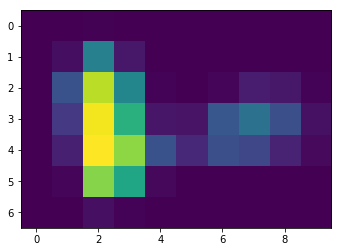

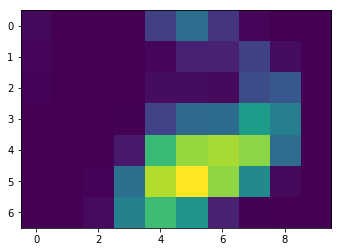

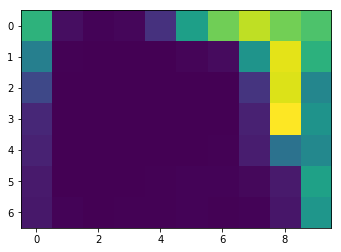

In [63]:
for filter_pos in range(5):
    plt.imshow(res_img[filter_pos][:,:,5])
    plt.show()

In [64]:
res.shape

torch.Size([5, 36, 7, 10, 7])

In [65]:
image_pos = 1
filter_pos = 20

In [66]:
grad = torch.mean(torch.abs(res[image_pos, filter_pos]))

In [67]:
grad.backward()

In [68]:
print(torch.sum(X.grad))

tensor(-3.7103)


In [69]:
print(torch.sum(X.grad))

tensor(-3.7103)


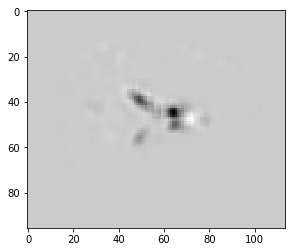

In [70]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

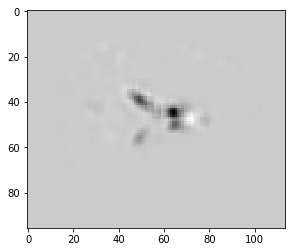

In [71]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

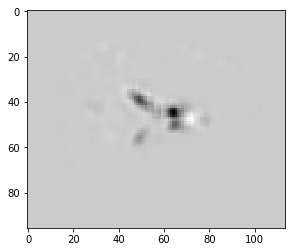

In [72]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

### Optimization loop

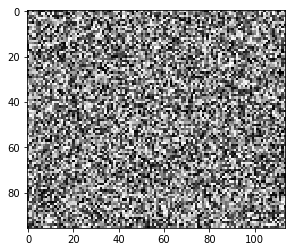

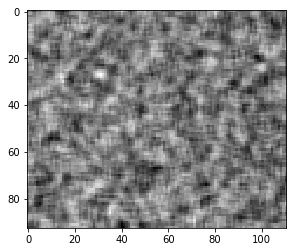

In [73]:
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

smoothed = F.conv3d(base, weight=gaussian_kernel, stride=1)
plt.imshow(smoothed.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

Iteration 0. Loss 0


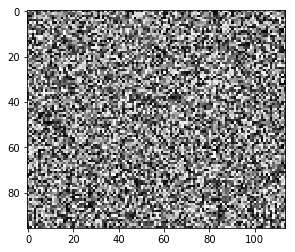

Iteration 200. Loss -198031.796875


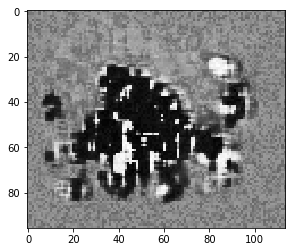

Iteration 400. Loss -418972.875


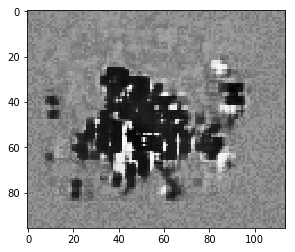

Iteration 600. Loss -610447.8125


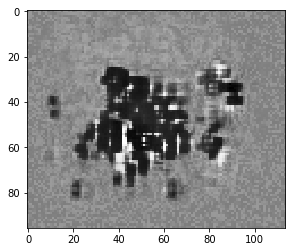

Iteration 800. Loss -771514.875


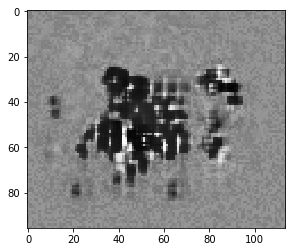

Iteration 1000. Loss -915710.9375


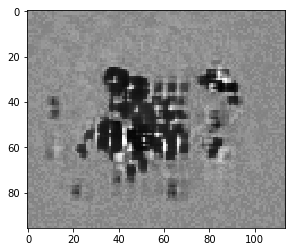

Iteration 1200. Loss -1037591.75


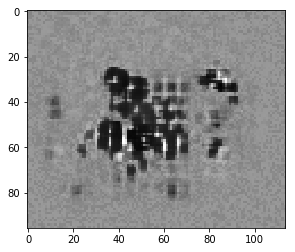

Iteration 1400. Loss -1137797.875


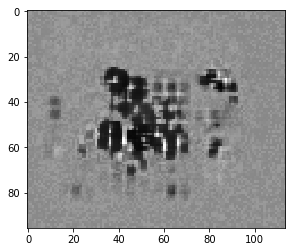

Iteration 1600. Loss -1225676.875


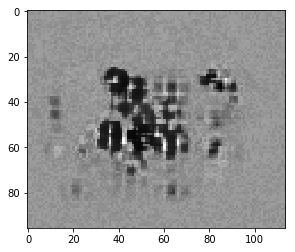

Iteration 1800. Loss -1298626.0


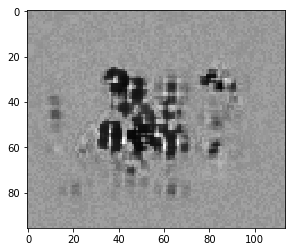

Iteration 2000. Loss -1361327.5


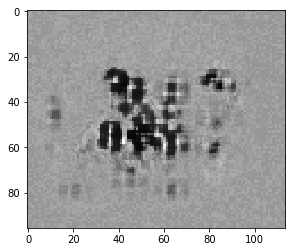

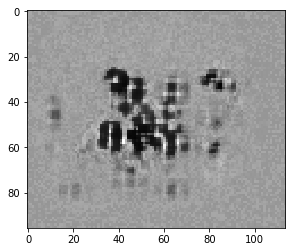

In [74]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [75]:
filter_pos = 10

Iteration 0. Loss 0


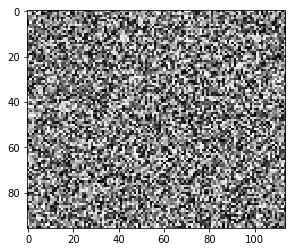

Iteration 200. Loss -872.0


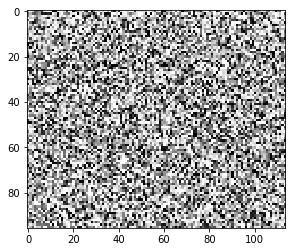

Iteration 400. Loss -872.0


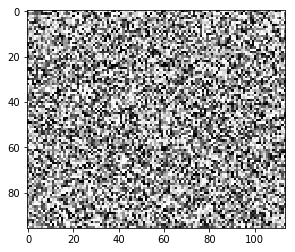

Iteration 600. Loss -872.0


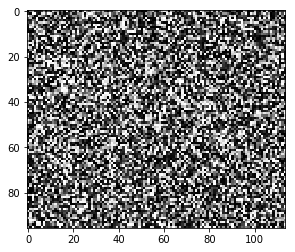

Iteration 800. Loss -872.0


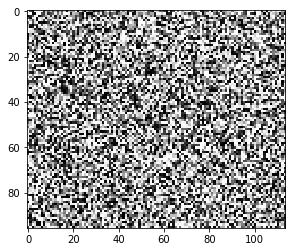

Iteration 1000. Loss -872.0


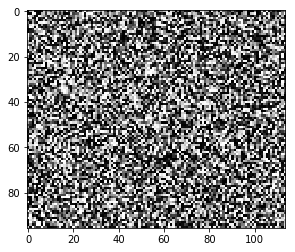

Iteration 1200. Loss -872.0


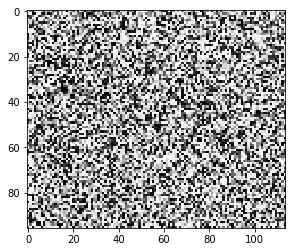

Iteration 1400. Loss -872.0


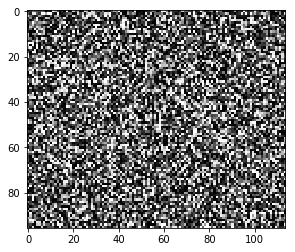

Iteration 1600. Loss -872.0


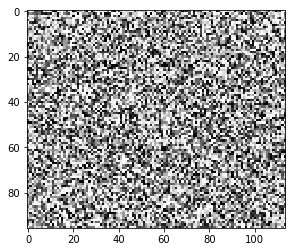

Iteration 1800. Loss -872.0


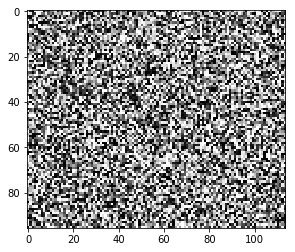

Iteration 2000. Loss -872.0


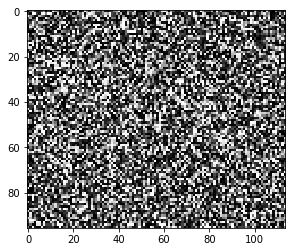

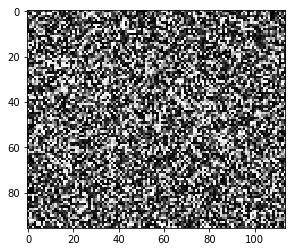

In [83]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [84]:
filter_pos = 34

Iteration 0. Loss 0


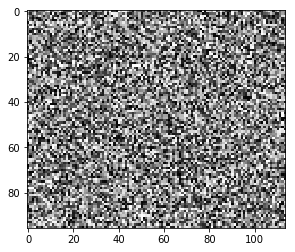

Iteration 200. Loss -784563.875


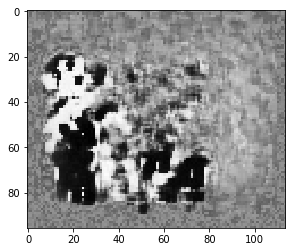

Iteration 400. Loss -1584918.75


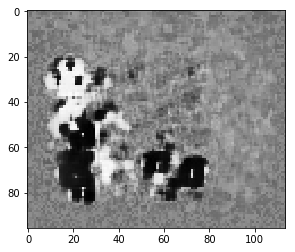

Iteration 600. Loss -2301621.5


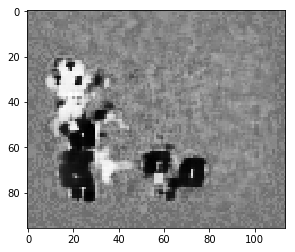

Iteration 800. Loss -2946641.25


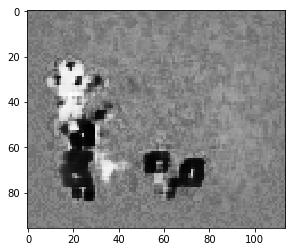

Iteration 1000. Loss -3524572.5


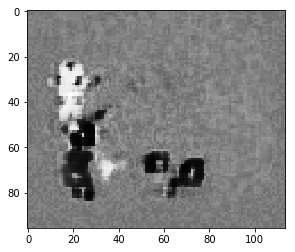

Iteration 1200. Loss -4049232.0


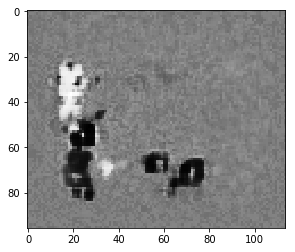

Iteration 1400. Loss -4538712.0


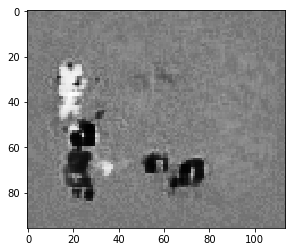

Iteration 1600. Loss -4988668.5


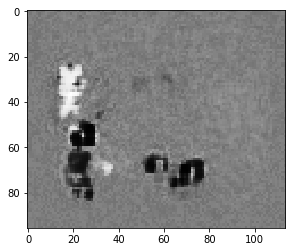

Iteration 1800. Loss -5400734.0


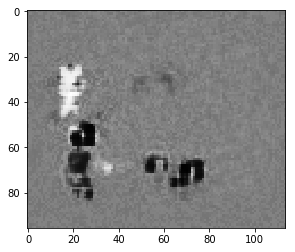

Iteration 2000. Loss -5802171.5


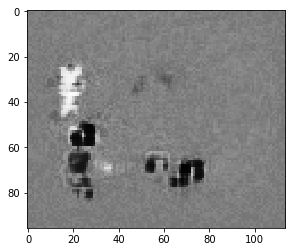

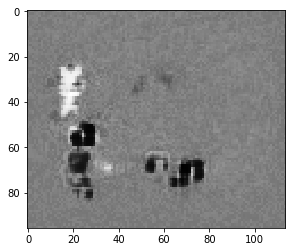

In [85]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [86]:
filter_pos = 35

Iteration 0. Loss 0


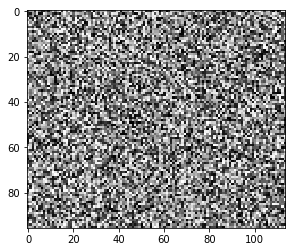

Iteration 200. Loss -3114153.25


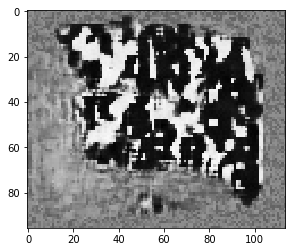

Iteration 400. Loss -6654048.5


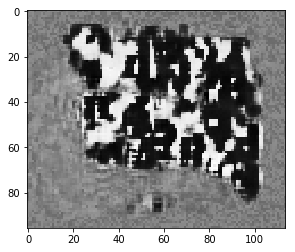

Iteration 600. Loss -10040358.0


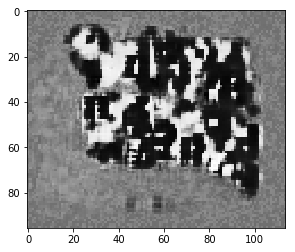

Iteration 800. Loss -13241588.0


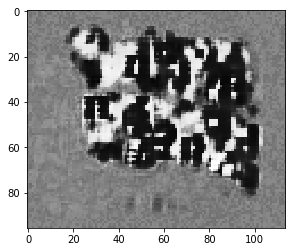

Iteration 1000. Loss -16263199.0


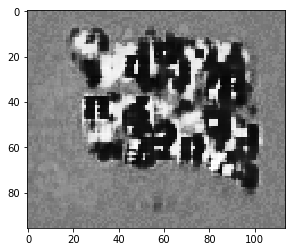

Iteration 1200. Loss -19112664.0


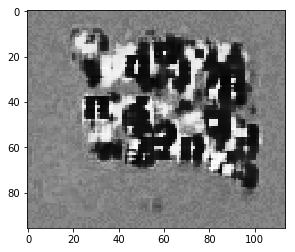

Iteration 1400. Loss -21795860.0


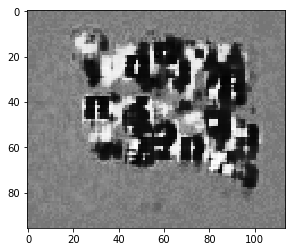

Iteration 1600. Loss -24325698.0


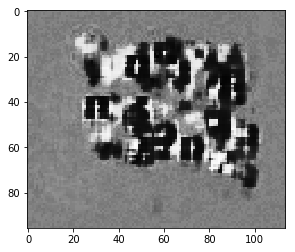

Iteration 1800. Loss -26709160.0


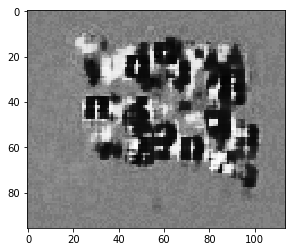

Iteration 2000. Loss -28957994.0


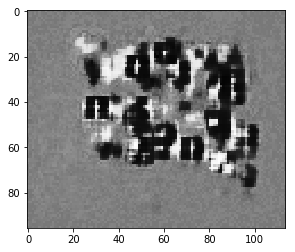

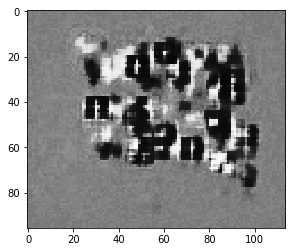

In [87]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [88]:
res = sub_model.forward(base.cuda(gpu))

In [89]:
torch.sum(torch.abs(res[0, filter_pos]))

tensor(29281080., device='cuda:1', grad_fn=<SumBackward0>)

In [90]:
torch.sum(torch.abs(res[0, filter_pos-14]))

tensor(280373., device='cuda:1', grad_fn=<SumBackward0>)

In [91]:
res = sub_model.forward(torch.unsqueeze(X[[0]], 1).cuda(gpu))

In [92]:
torch.sum(torch.abs(res[0, filter_pos]))

tensor(7971.2856, device='cuda:1', grad_fn=<SumBackward0>)

In [93]:
torch.sum(torch.abs(res[0, filter_pos-14]))

tensor(1011.9040, device='cuda:1', grad_fn=<SumBackward0>)

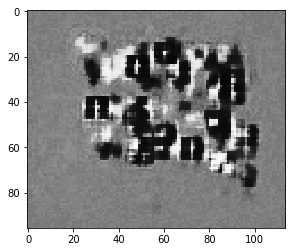

In [94]:
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

## Using other Layer as output

In [95]:
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)

        self.blur = blur_kernel

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))      
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1)
        x = self.encode(x, print_size=print_size)
        #x = self.flatten(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [96]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
Conv_4.weight
Conv_4.bias


SubModel(
  (dropout): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
)

In [97]:
filter_pos = 1

Iteration 0. Loss 0


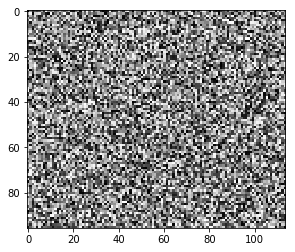

Iteration 200. Loss -962.0


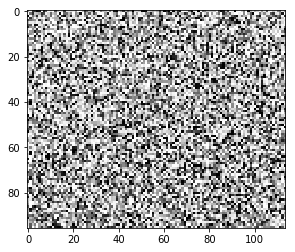

Iteration 400. Loss -962.0


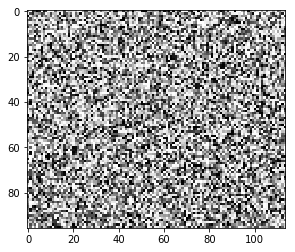

Iteration 600. Loss -962.0


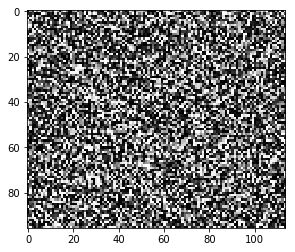

Iteration 800. Loss -962.0


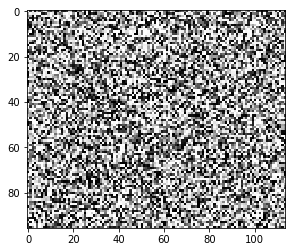

Iteration 1000. Loss -962.0


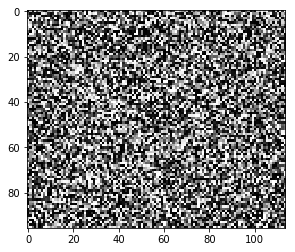

Iteration 1200. Loss -962.0


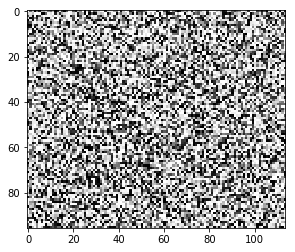

Iteration 1400. Loss -962.0


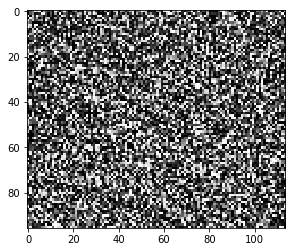

Iteration 1600. Loss -962.0


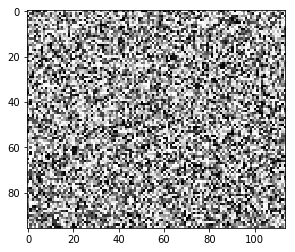

Iteration 1800. Loss -962.0


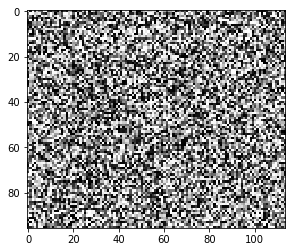

Iteration 2000. Loss -962.0


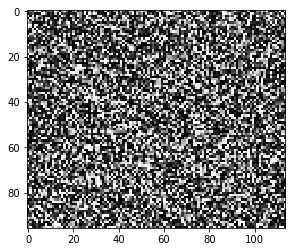

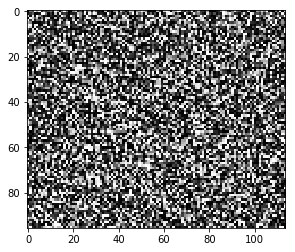

In [98]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [99]:
filter_pos = 2

Iteration 0. Loss 0


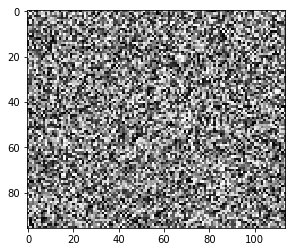

Iteration 200. Loss -271587.6875


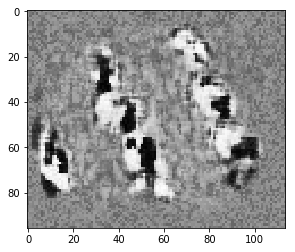

Iteration 400. Loss -568933.375


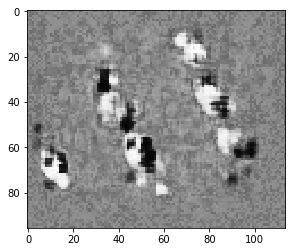

Iteration 600. Loss -770630.4375


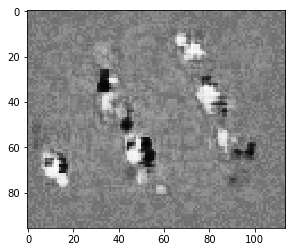

Iteration 800. Loss -916282.0


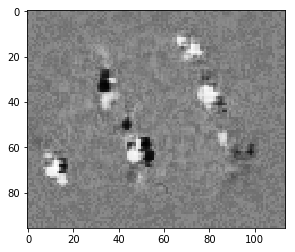

Iteration 1000. Loss -1025978.9375


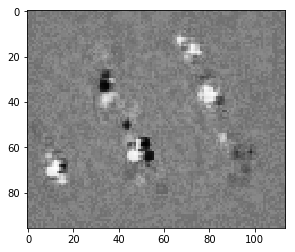

Iteration 1200. Loss -1110243.125


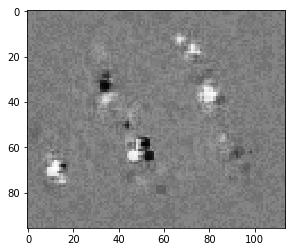

Iteration 1400. Loss -1177058.875


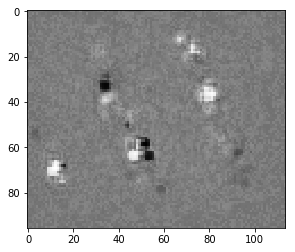

Iteration 1600. Loss -1230935.625


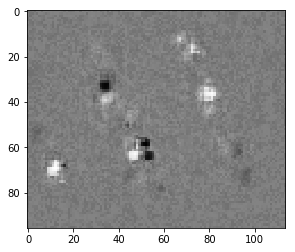

Iteration 1800. Loss -1275315.125


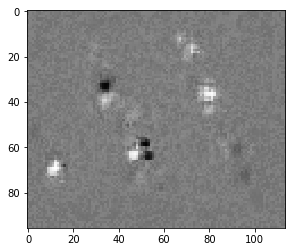

Iteration 2000. Loss -1313195.875


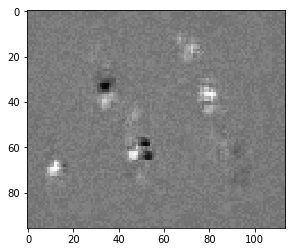

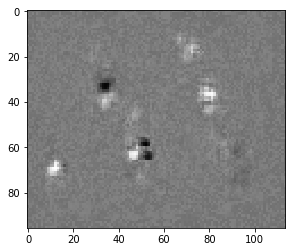

In [100]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters + 1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
        plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
        plt.show()
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

## Early layers

In [101]:
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)

        self.blur = blur_kernel

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))  
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1)
        x = self.encode(x, print_size=print_size)
        #x = self.flatten(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [102]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias


SubModel(
  (dropout): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
)

In [103]:
def optimize_activations(sub_model, base, optimizer, filter_pos=0, num_iters=2000, show_x=200):
    loss = 0
    l1_loss = nn.L1Loss(reduction='mean')
    
    for i in range(num_iters + 1):
        if i % show_x == 0:
            print("Iteration {}. Loss {}".format(i, loss))
            plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
            plt.show()
        #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
        sub_model.zero_grad()

        res = sub_model.forward(base.cuda(gpu))
        l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
        #print(l1)
        loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
        #print(loss)
        loss.backward()
        optimizer.step()
    print("Final output:")
    plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
    plt.show()

Filter position: 1
Iteration 0. Loss 0


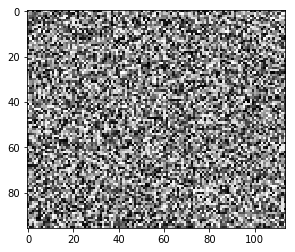

Final output:


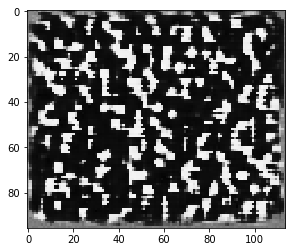

In [104]:
filter_pos = 1
print("Filter position: {}".format(filter_pos)) 
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

optimize_activations(sub_model, base, optimizer, filter_pos=filter_pos, num_iters=num_iters, show_x=num_iters+1)

Filter position: 13
Iteration 0. Loss 0


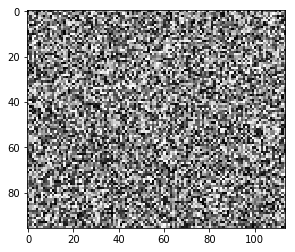

Final output:


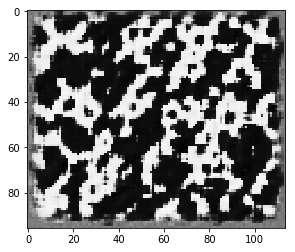

Filter position: 14
Iteration 0. Loss 0


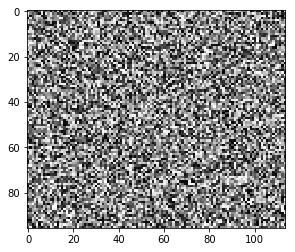

Final output:


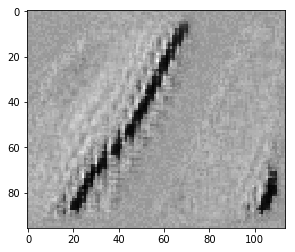

Filter position: 15
Iteration 0. Loss 0


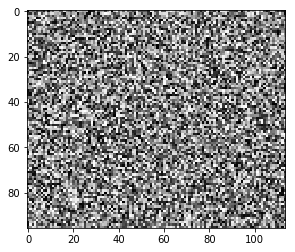

Final output:


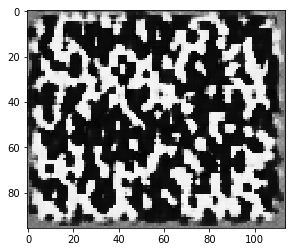

Filter position: 26
Iteration 0. Loss 0


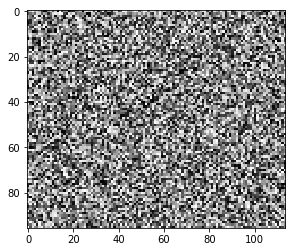

Final output:


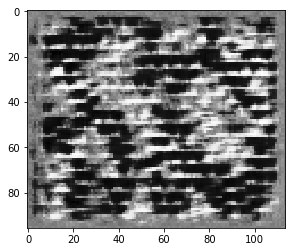

Filter position: 27
Iteration 0. Loss 0


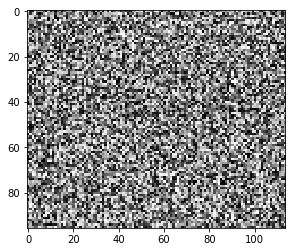

Final output:


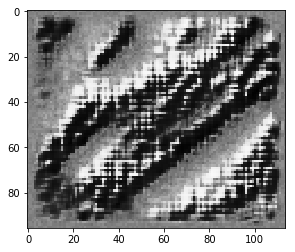

Filter position: 28
Iteration 0. Loss 0


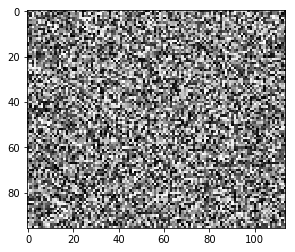

Final output:


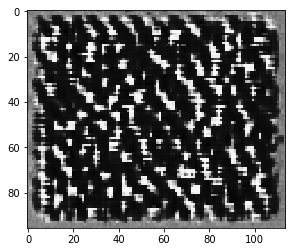

Filter position: 39
Iteration 0. Loss 0


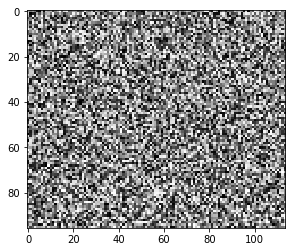

Final output:


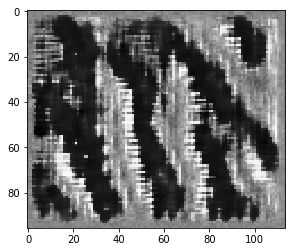

Filter position: 40
Iteration 0. Loss 0


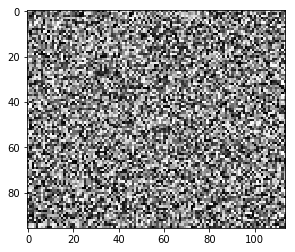

Final output:


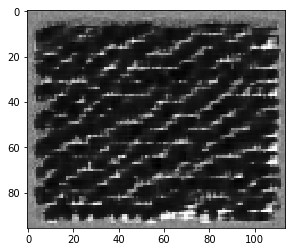

Filter position: 41
Iteration 0. Loss 0


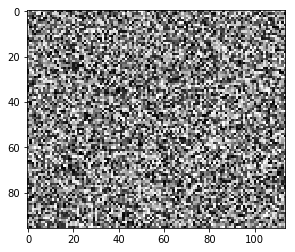

Final output:


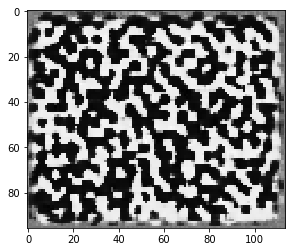

Filter position: 61
Iteration 0. Loss 0


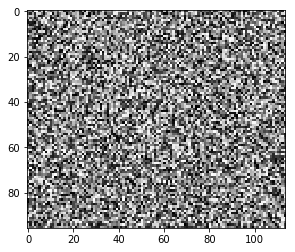

Final output:


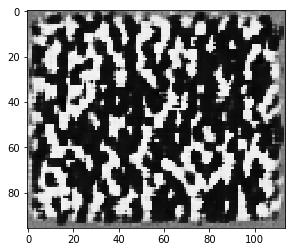

Filter position: 62
Iteration 0. Loss 0


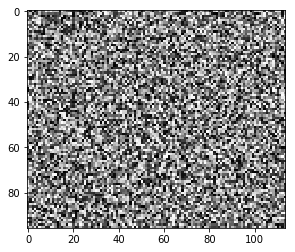

Final output:


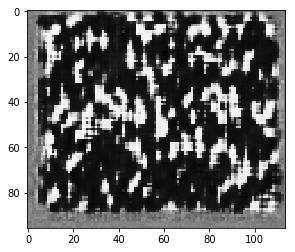

Filter position: 63
Iteration 0. Loss 0


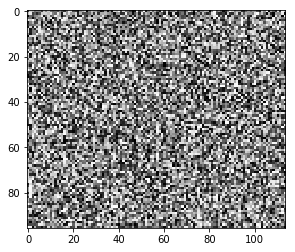

Final output:


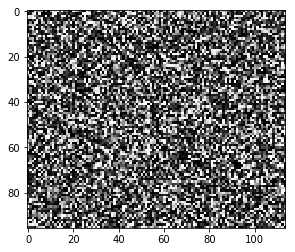

In [105]:
for filter_pos in [13, 14, 15, 26, 27, 28, 39, 40, 41, 61, 62, 63]:
    print("Filter position: {}".format(filter_pos)) 
    num_iters = 2000
    base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
    optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

    optimize_activations(sub_model, base, optimizer, filter_pos=filter_pos, num_iters=num_iters, show_x=num_iters+1)

First layer only

In [106]:
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3, blur_kernel=None):
        super(SubModel, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.blur = blur_kernel

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x)) 
        return x

    def forward(self, x):
        print_size = False
        if self.blur is not None:
            x = F.conv3d(x, weight=self.blur.cuda(gpu), stride=1)
        x = self.encode(x, print_size=print_size)
        #x = self.flatten(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [107]:
sub_model = SubModel(blur_kernel=gaussian_kernel)

new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

sub_model.load_state_dict(new_state_dict)

sub_model.cuda(gpu)
sub_model.eval()

Conv_1.weight
Conv_1.bias


SubModel(
  (dropout): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
)

Filter position: 13
Iteration 0. Loss 0


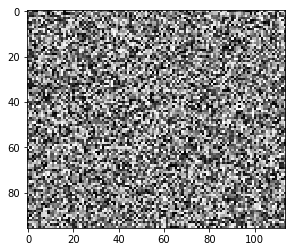

Final output:


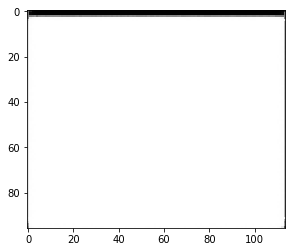

Filter position: 14
Iteration 0. Loss 0


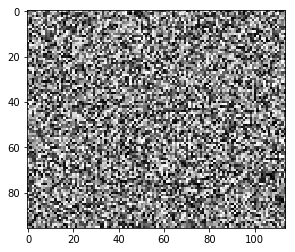

Final output:


Filter position: 15
Iteration 0. Loss 0


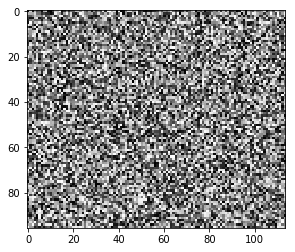

Final output:


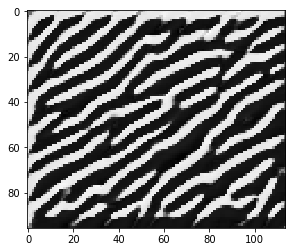

Filter position: 26
Iteration 0. Loss 0


Final output:


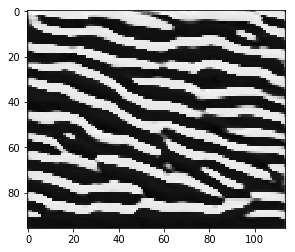

Filter position: 27
Iteration 0. Loss 0


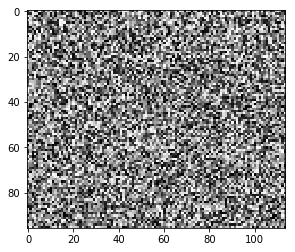

Final output:


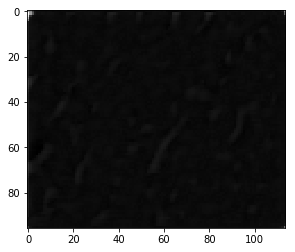

Filter position: 28
Iteration 0. Loss 0


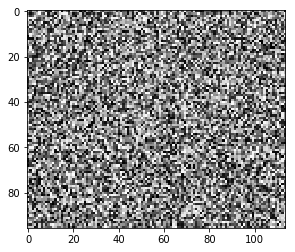

Final output:


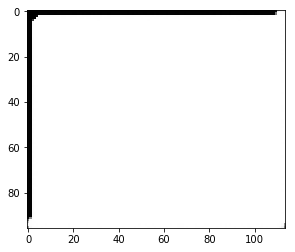

Filter position: 39
Iteration 0. Loss 0


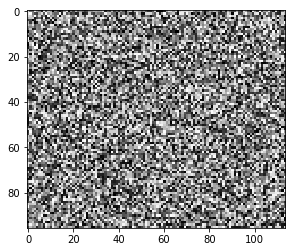

Final output:


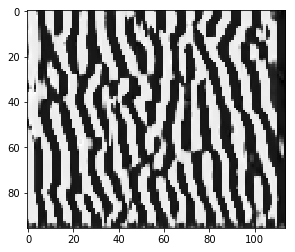

Filter position: 40
Iteration 0. Loss 0


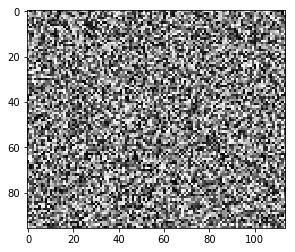

Final output:


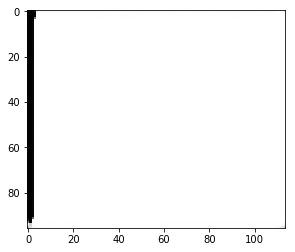

Filter position: 41
Iteration 0. Loss 0


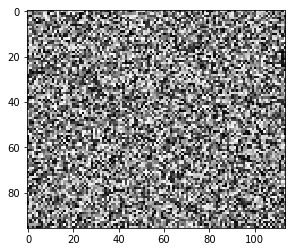

Final output:


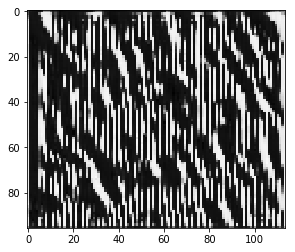

Filter position: 61
Iteration 0. Loss 0


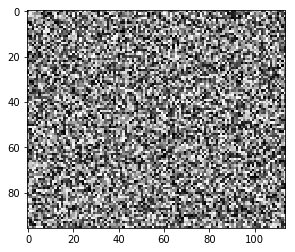

Final output:


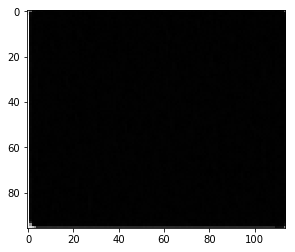

Filter position: 62
Iteration 0. Loss 0


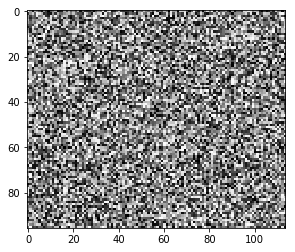

Final output:


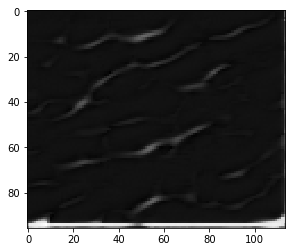

Filter position: 63
Iteration 0. Loss 0


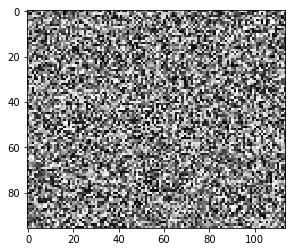

Final output:


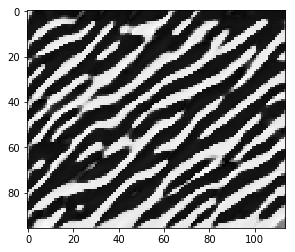

In [108]:
for filter_pos in [13, 14, 15, 26, 27, 28, 39, 40, 41, 61, 62, 63]:
    print("Filter position: {}".format(filter_pos)) 
    num_iters = 2000
    base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
    optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

    optimize_activations(sub_model, base, optimizer, filter_pos=filter_pos, num_iters=num_iters, show_x=num_iters+1)

## Add transformation robustness

In [116]:
from torchvision import transforms
from nitorch.transforms import Translate, Rotate, Flip

In [110]:
def optimize_activations(sub_model, base, optimizer, filter_pos=0, num_iters=2000, show_x=200, ps=6,transforms=None):
    loss = 0
    l1_loss = nn.L1Loss(reduction='mean')
    
    for i in range(num_iters + 1):
        base = base.detach()
        base = F.pad(base, pad=(ps,ps,ps,ps,ps,ps))
        if transforms:
            base = transforms(base)
        base = base[:,:,ps:-ps,ps:-ps,ps:-ps]
        if i % show_x == 0:
            print("Iteration {}. Loss {}".format(i, loss))
            plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
            plt.show()
        #base = F.conv3d(base, weight=gaussian_kernel, stride=1)  
        sub_model.zero_grad()
        res = sub_model.forward(base.cuda(gpu))            
        l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
        #print(l1)
        loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 10
        #print(loss)
        loss.backward()
        optimizer.step()
    print("Final output:")
    plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
    plt.show()

In [111]:
class TranslateTorch:
    """
    Translate the input along a given axis.

    Arguments:
        axis: axis to rotate. Default is 0
        dist: min and max translation distance in pixels. Randomly 
            translates within that range. Can be scalar, list or tuple. 
            In case of scalar it translates between -abs(dist) and 
            abs(dist). Default is (-3, 3).
    """

    def __init__(self, axis=0, dist=(-3, 3)):
        self.axis = axis

        if isinstance(dist, tuple) or isinstance(dist, list):
            assert len(dist) == 2
            self.min_trans = np.min(dist)
            self.max_trans = np.max(dist)
        else:
            self.min_trans = -int(abs(dist))
            self.max_trans = int(abs(dist))

    def __call__(self, image):
        rand = np.random.randint(self.min_trans, self.max_trans + 1)
        #augmented = torch.zeros(size=image.shape)
        augmented = image.clone()
        #augmented[:] = 0
        if self.axis == 0:
            if rand < 0:
                augmented[:,:,-rand:, :] = image[:,:,:rand, :]
            elif rand > 0:
                augmented[:,:,:-rand, :] = image[:,:,rand:, :]
            else:
                augmented = image
        elif self.axis == 1:
            if rand < 0:
                augmented[:,:,:, -rand:, :] = image[:,:,:, :rand, :]
            elif rand > 0:
                augmented[:,:,:, :-rand, :] = image[:,:,:, rand:, :]
            else:
                augmented = image
        elif self.axis == 2:
            if rand < 0:
                augmented[:,:,:, :, -rand:] = image[:,:,:, :, :rand]
            elif rand > 0:
                augmented[:,:,:, :, :-rand] = image[:,:,:, :, rand:]
            else:
                augmented = image
        image = augmented
        #image[0,0,3,:,:] = 0
        return image

In [112]:
class FlipTorch:
    """
    Flip the input along a given axis.

    Arguments:
        axis: axis to flip over. Default is 0
        prob: probability to flip the image. Executes always when set to
             1. Default is 0.5
    """

    def __init__(self, axis=0, prob=0.5):
        self.axis = axis
        self.prob = prob

    def __call__(self, image):
        rand = np.random.uniform()
        if rand <= self.prob:
            augmented = torch.flip(image, dims=(self.axis,))
        else:
            augmented = image
        return augmented

In [113]:
trans_1 = [TranslateTorch(axis=dim, dist=8) for dim in [0, 1, 2]]
trans_2 = [TranslateTorch(axis=dim, dist=3) for dim in [0, 1, 2]]
#rot = [Rotate(axis=dim, deg=5) for dim in [0, 1, 2]]
flip = [FlipTorch(axis=dim, prob=0.5) for dim in [0]] #, 1, 2]] USING ONLY ONE


In [114]:
#transf = transforms.Compose(trans_1 + flip + trans_2)
transf = transforms.Compose(trans_2)

Filter position: 1
Iteration 0. Loss 0


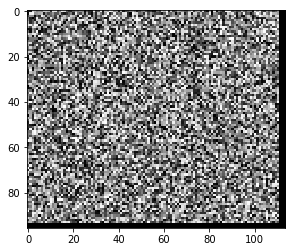

Iteration 1. Loss -925652.5625


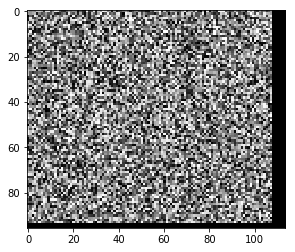

Iteration 2. Loss -937668.25


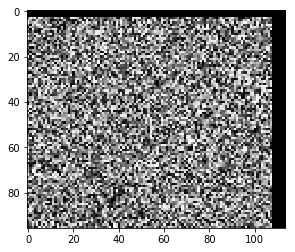

Iteration 3. Loss -965354.125


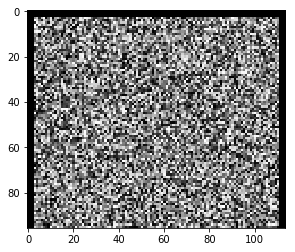

Iteration 4. Loss -944841.6875


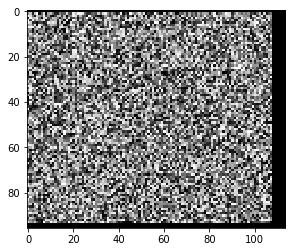

Iteration 5. Loss -962940.1875


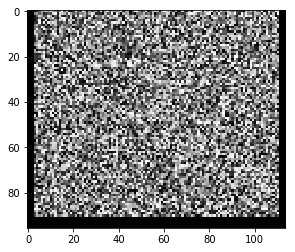

Iteration 6. Loss -939442.625


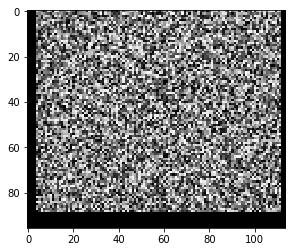

Iteration 7. Loss -891224.75


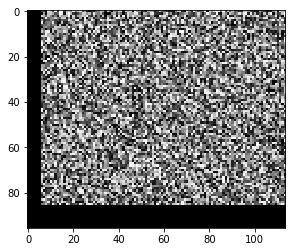

Iteration 8. Loss -844087.875


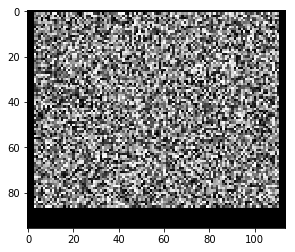

Iteration 9. Loss -851379.0625


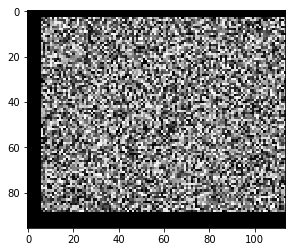

Iteration 10. Loss -836654.625


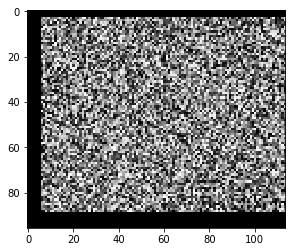

Iteration 11. Loss -855363.625


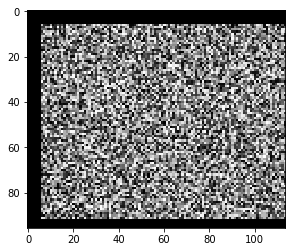

Iteration 12. Loss -831496.9375


Iteration 13. Loss -804179.6875


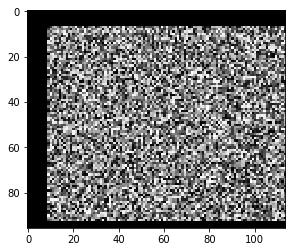

Iteration 14. Loss -757207.0625


Iteration 15. Loss -736423.0625


Iteration 16. Loss -755683.5625


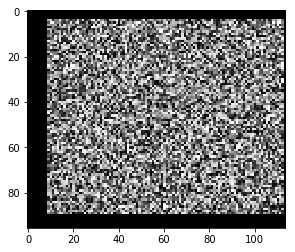

Iteration 17. Loss -715395.75


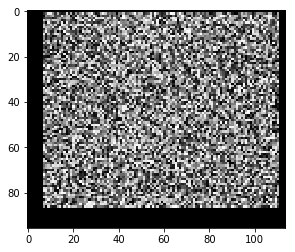

Iteration 18. Loss -727290.0625


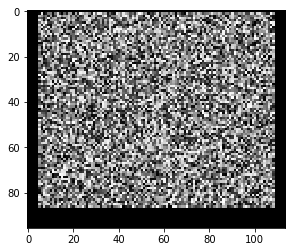

Iteration 19. Loss -781650.75


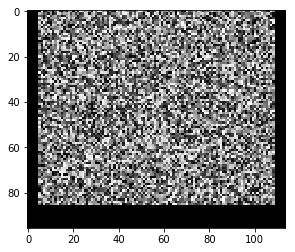

Iteration 20. Loss -773813.1875


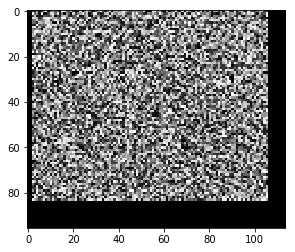

Iteration 21. Loss -721123.75


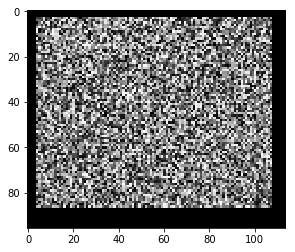

Iteration 22. Loss -723722.5


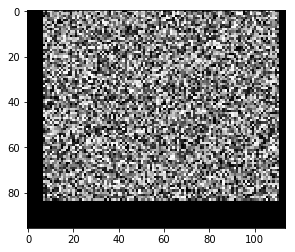

Iteration 23. Loss -668765.4375


Iteration 24. Loss -686586.75


Iteration 25. Loss -722505.875


Iteration 26. Loss -692485.3125


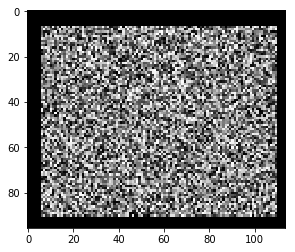

Iteration 27. Loss -703512.125


Iteration 28. Loss -692013.0625


Iteration 29. Loss -641134.75


Iteration 30. Loss -640474.5625


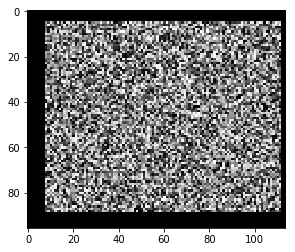

Iteration 31. Loss -674509.875


Iteration 32. Loss -686462.75


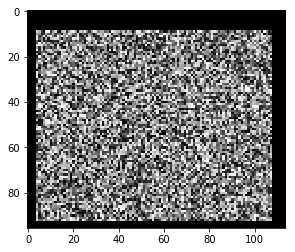

Iteration 33. Loss -675082.0


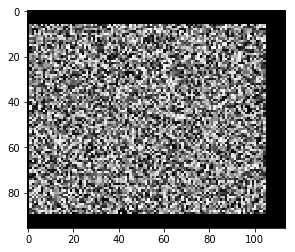

Iteration 34. Loss -688046.75


Iteration 35. Loss -672645.125


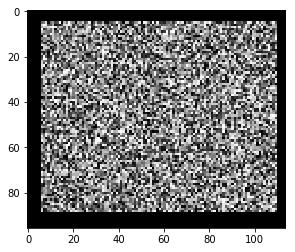

Iteration 36. Loss -647946.8125


Iteration 37. Loss -669022.125


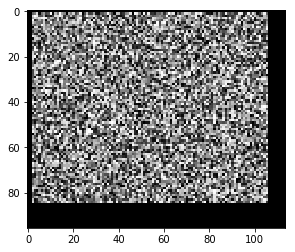

Iteration 38. Loss -621869.4375


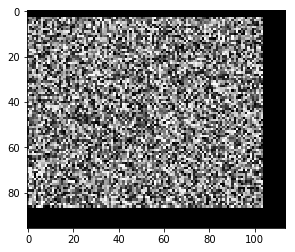

Iteration 39. Loss -646829.9375


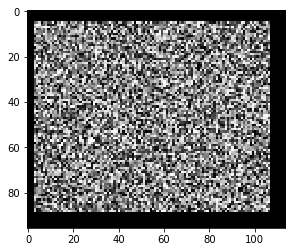

Iteration 40. Loss -644883.625


Iteration 41. Loss -663766.875


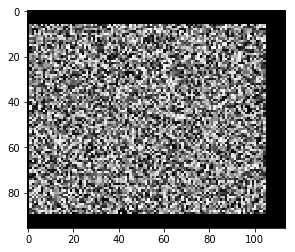

Iteration 42. Loss -678999.6875


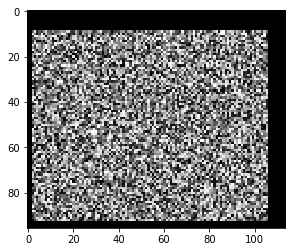

Iteration 43. Loss -672879.6875


Iteration 44. Loss -661886.3125


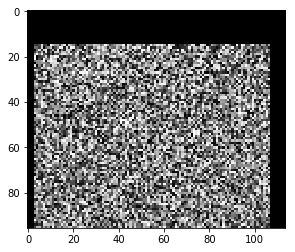

Iteration 45. Loss -633280.875


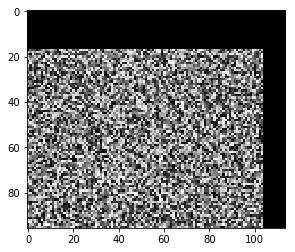

Iteration 46. Loss -601974.5625


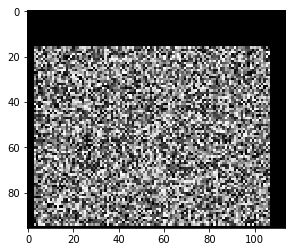

Iteration 47. Loss -625401.0


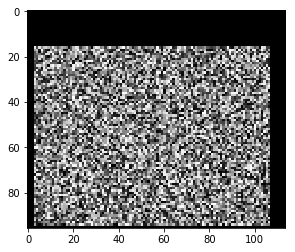

Iteration 48. Loss -625400.9375


Iteration 49. Loss -618935.75


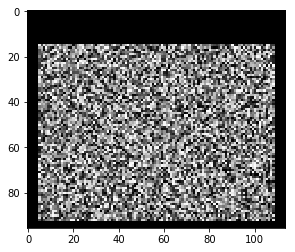

Iteration 50. Loss -641013.125


Iteration 51. Loss -634591.625


Iteration 52. Loss -634591.5625


Iteration 53. Loss -631652.875


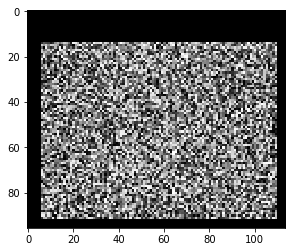

Iteration 54. Loss -640919.625


Iteration 55. Loss -605661.8125


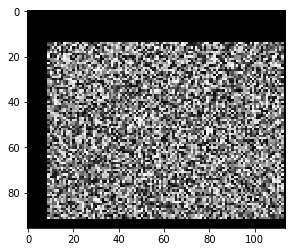

Iteration 56. Loss -607914.25


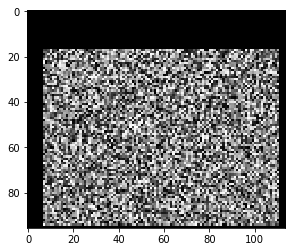

Iteration 57. Loss -605661.8125


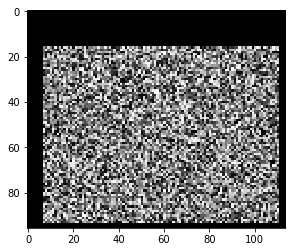

Iteration 58. Loss -612773.625


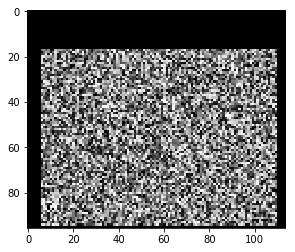

Iteration 59. Loss -604393.3125


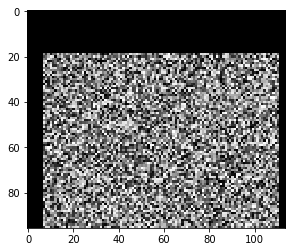

Iteration 60. Loss -566845.375


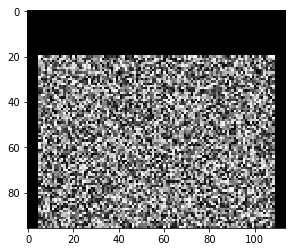

Iteration 61. Loss -571637.875


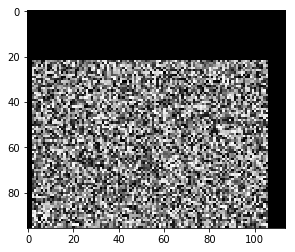

Iteration 62. Loss -559252.0


Iteration 63. Loss -536904.6875


Iteration 64. Loss -554206.5


Iteration 65. Loss -593833.9375


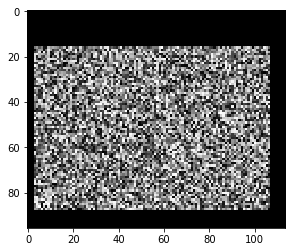

Iteration 66. Loss -581427.0


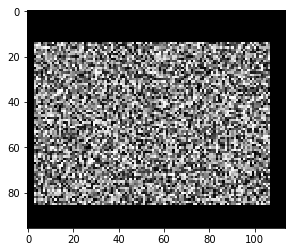

Iteration 67. Loss -557570.4375


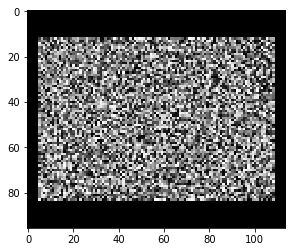

Iteration 68. Loss -541614.625


Iteration 69. Loss -513791.3125


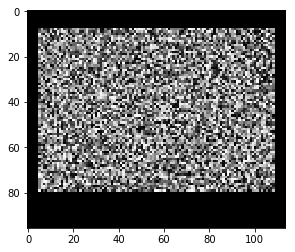

Iteration 70. Loss -541596.25


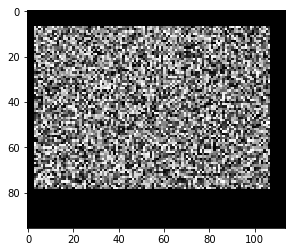

Iteration 71. Loss -525875.6875


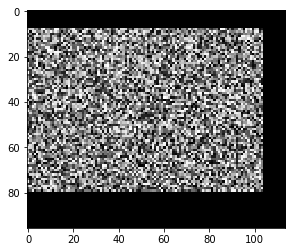

Iteration 72. Loss -489512.96875


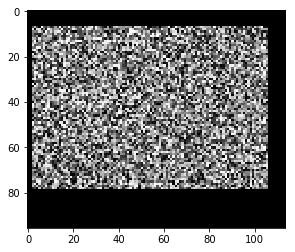

Iteration 73. Loss -474419.1875


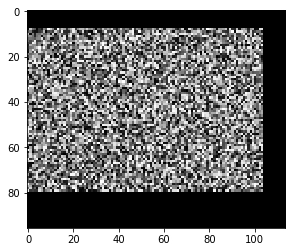

Iteration 74. Loss -450824.53125


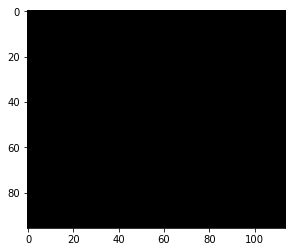

Iteration 75. Loss -423585.21875


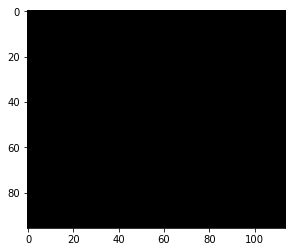

Iteration 76. Loss -389705.875


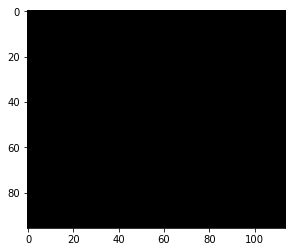

Iteration 77. Loss -389705.84375


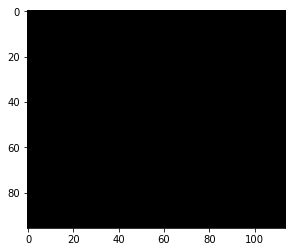

Iteration 78. Loss -396627.25


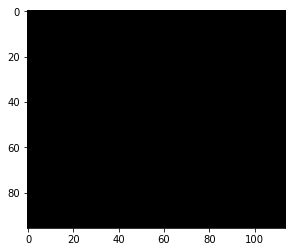

Iteration 79. Loss -391812.90625


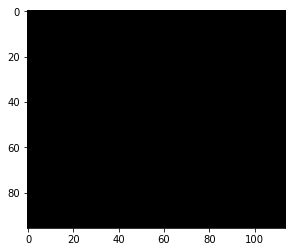

Iteration 80. Loss -370370.15625


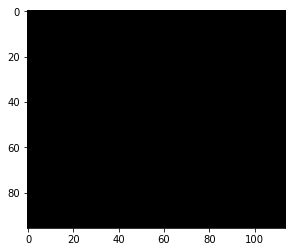

Iteration 81. Loss -391474.65625


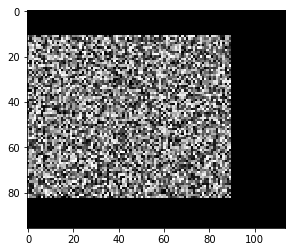

Iteration 82. Loss -386419.46875


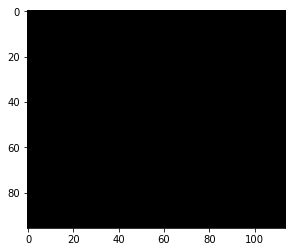

Iteration 83. Loss -362733.78125


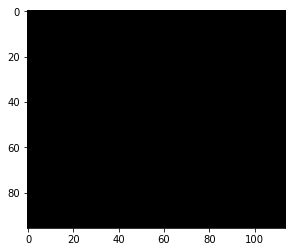

Iteration 84. Loss -346222.5


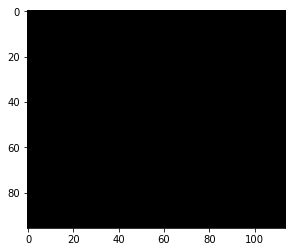

Iteration 85. Loss -355522.75


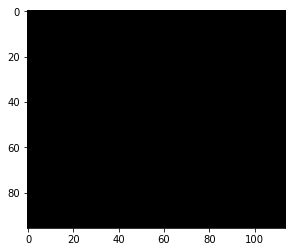

Iteration 86. Loss -345711.46875


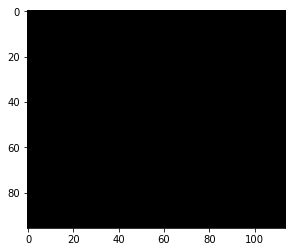

Iteration 87. Loss -339507.375


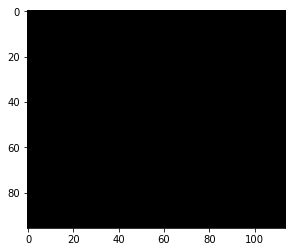

Iteration 88. Loss -325385.09375


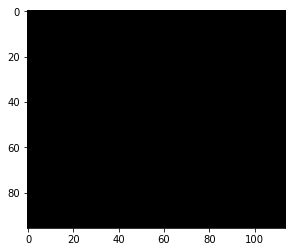

Iteration 89. Loss -334942.4375


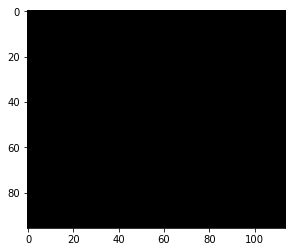

Iteration 90. Loss -316948.40625


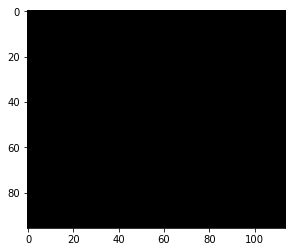

Iteration 91. Loss -303896.71875


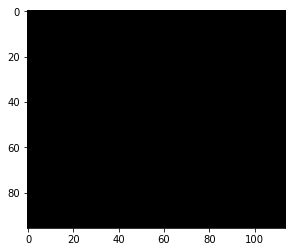

Iteration 92. Loss -303870.25


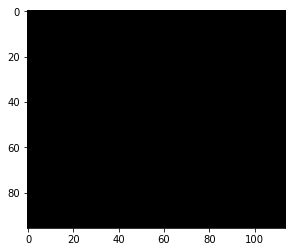

Iteration 93. Loss -314033.09375


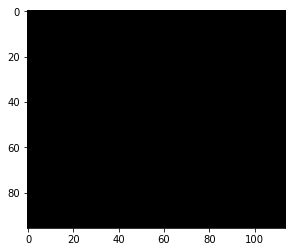

Iteration 94. Loss -310393.3125


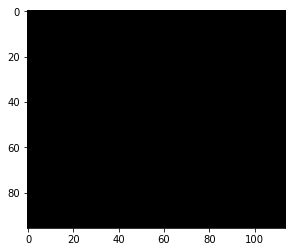

Iteration 95. Loss -317577.84375


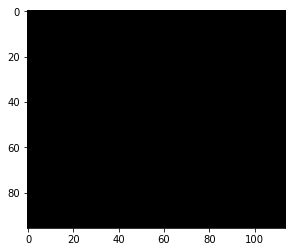

Iteration 96. Loss -320625.75


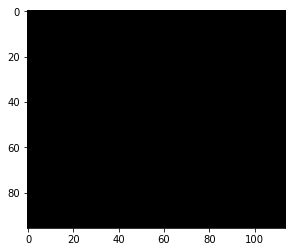

Iteration 97. Loss -321915.875


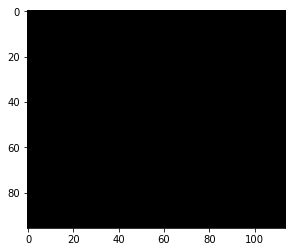

Iteration 98. Loss -310769.65625


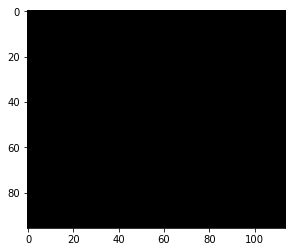

Iteration 99. Loss -308610.78125


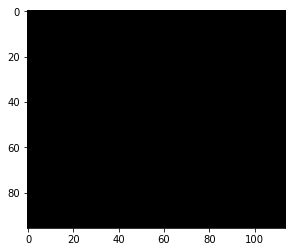

Iteration 100. Loss -316279.5


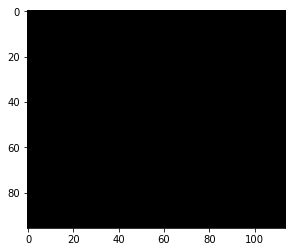

Iteration 101. Loss -315741.0625


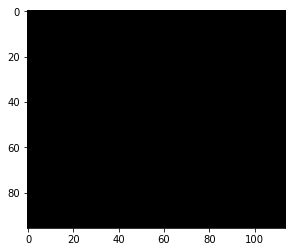

Iteration 102. Loss -328573.6875


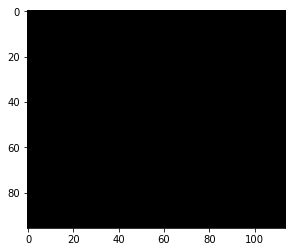

Iteration 103. Loss -322468.0


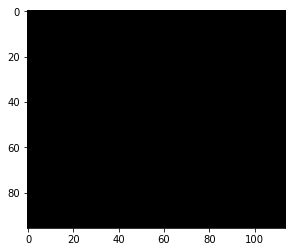

Iteration 104. Loss -311450.28125


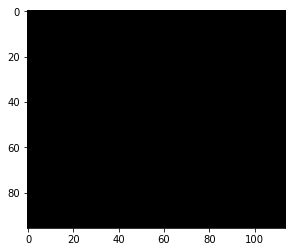

Iteration 105. Loss -298980.40625


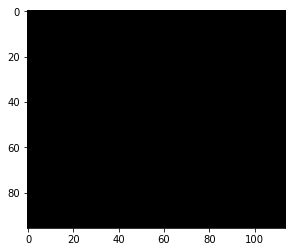

Iteration 106. Loss -292777.875


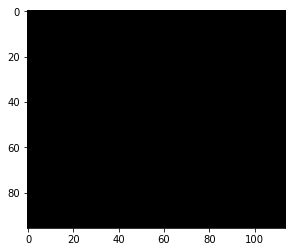

Iteration 107. Loss -316207.375


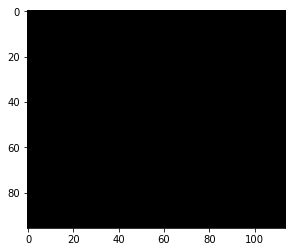

Iteration 108. Loss -310007.90625


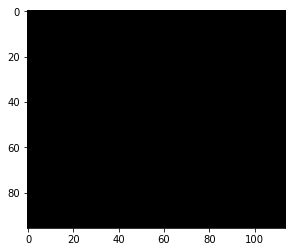

Iteration 109. Loss -310007.90625


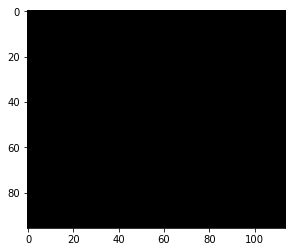

Iteration 110. Loss -310007.875


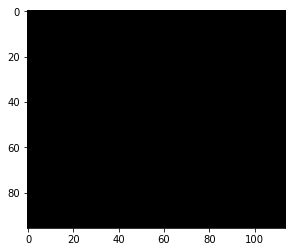

Iteration 111. Loss -316207.40625


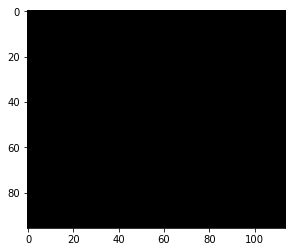

Iteration 112. Loss -310007.90625


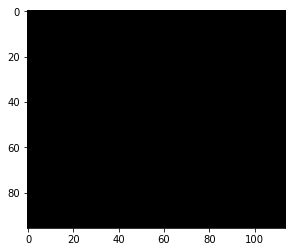

Iteration 113. Loss -296860.28125


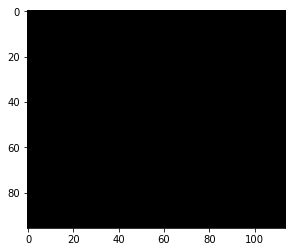

Iteration 114. Loss -283993.25


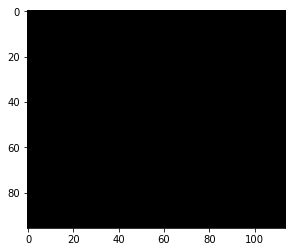

Iteration 115. Loss -259032.484375


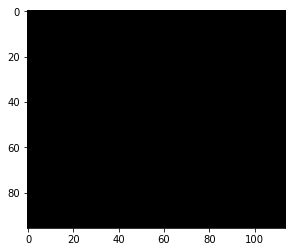

Iteration 116. Loss -272733.53125


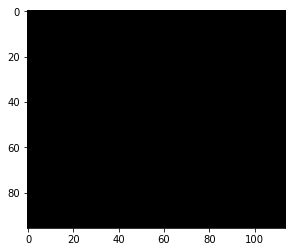

Iteration 117. Loss -249416.578125


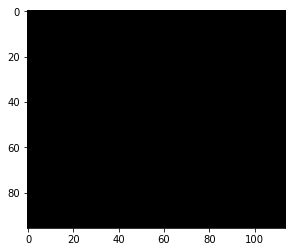

Iteration 118. Loss -234421.203125


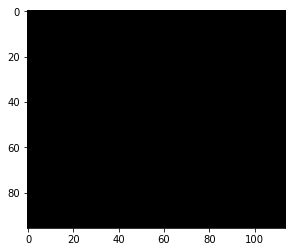

Iteration 119. Loss -237525.25


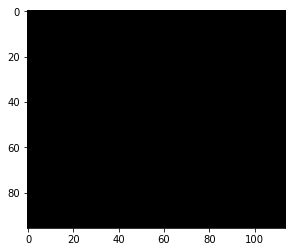

Iteration 120. Loss -247256.671875


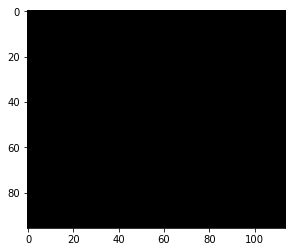

Iteration 121. Loss -264451.375


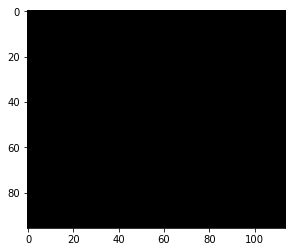

Iteration 122. Loss -269447.96875


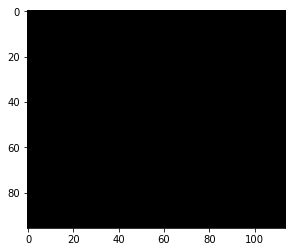

Iteration 123. Loss -269923.3125


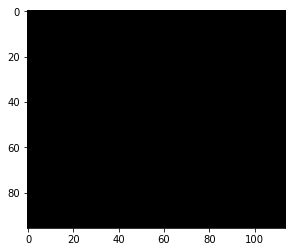

Iteration 124. Loss -269447.96875


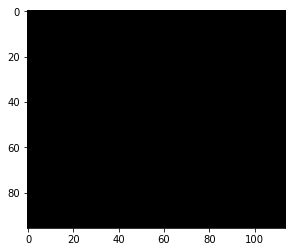

Iteration 125. Loss -257714.125


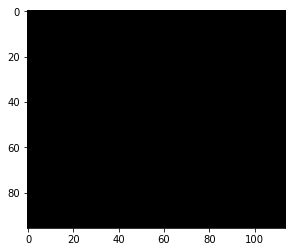

Iteration 126. Loss -250741.109375


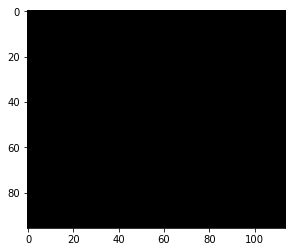

Iteration 127. Loss -260373.765625


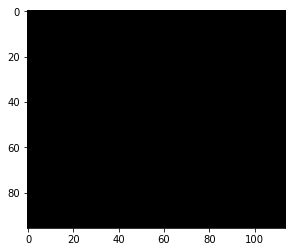

Iteration 128. Loss -252617.796875


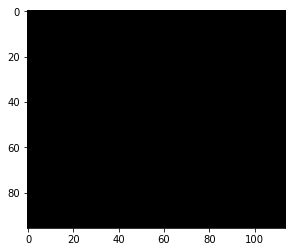

Iteration 129. Loss -257714.125


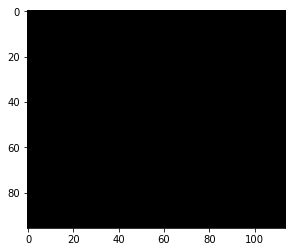

Iteration 130. Loss -263989.96875


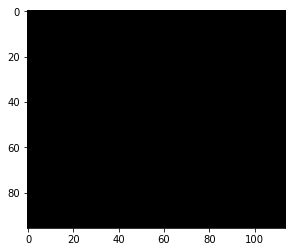

Iteration 131. Loss -269447.9375


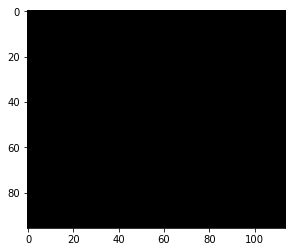

Iteration 132. Loss -249183.734375


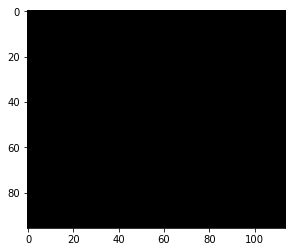

Iteration 133. Loss -246840.609375


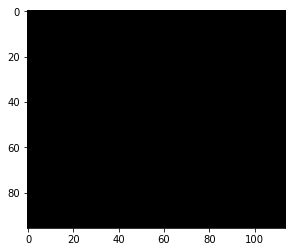

Iteration 134. Loss -249183.734375


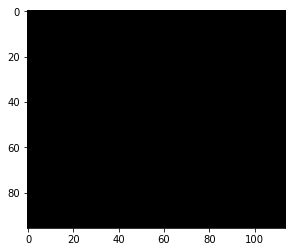

Iteration 135. Loss -240920.703125


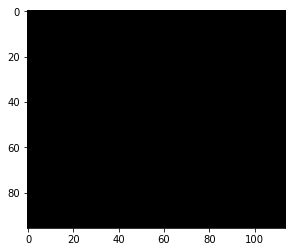

Iteration 136. Loss -214368.84375


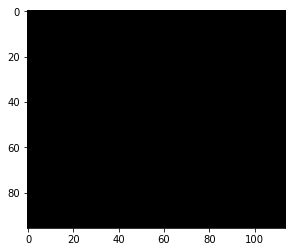

Iteration 137. Loss -201191.015625


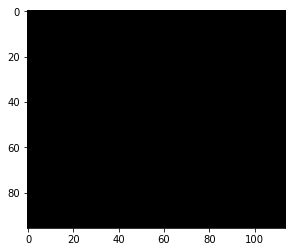

Iteration 138. Loss -190142.890625


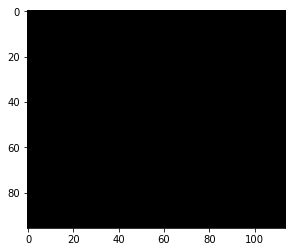

Iteration 139. Loss -184587.703125


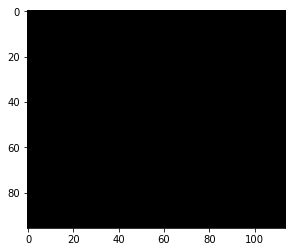

Iteration 140. Loss -198206.640625


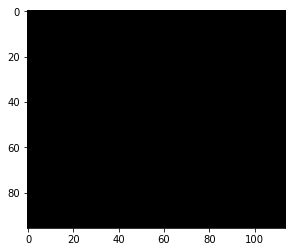

Iteration 141. Loss -208282.71875


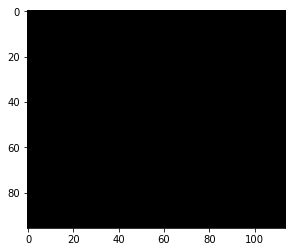

Iteration 142. Loss -216636.3125


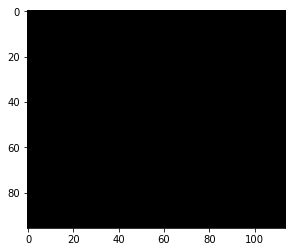

Iteration 143. Loss -219936.484375


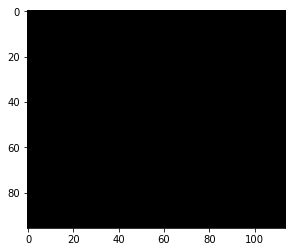

Iteration 144. Loss -219567.53125


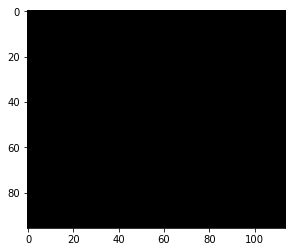

Iteration 145. Loss -219936.484375


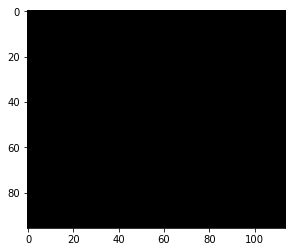

Iteration 146. Loss -219567.53125


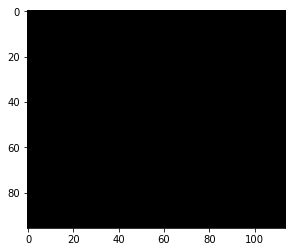

Iteration 147. Loss -219936.5


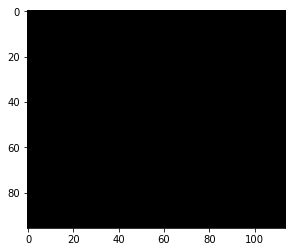

Iteration 148. Loss -219567.53125


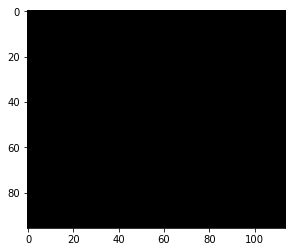

Iteration 149. Loss -214386.65625


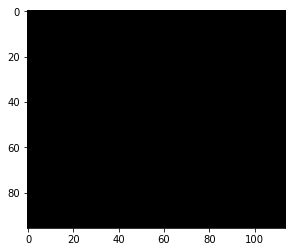

Iteration 150. Loss -219567.53125


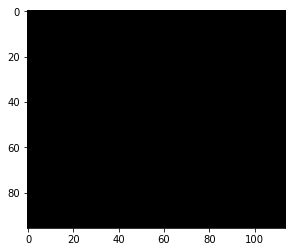

Iteration 151. Loss -211622.421875


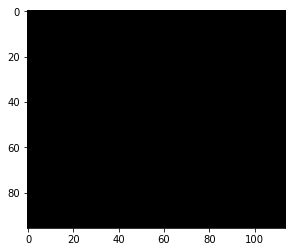

Iteration 152. Loss -214386.640625


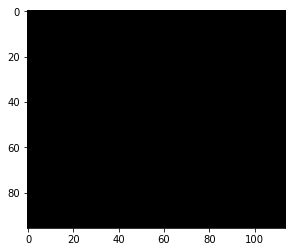

Iteration 153. Loss -204918.453125


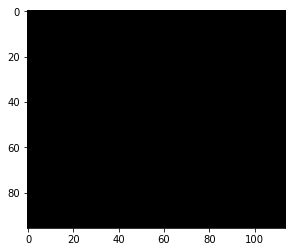

Iteration 154. Loss -194832.15625


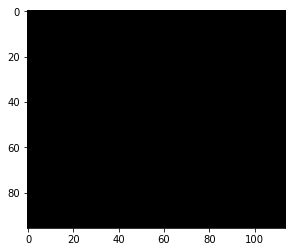

Iteration 155. Loss -189805.734375


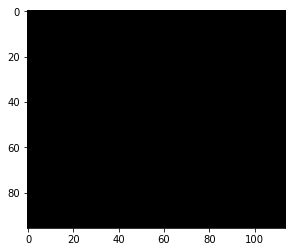

Iteration 156. Loss -198159.640625


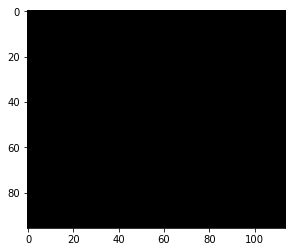

Iteration 157. Loss -194880.15625


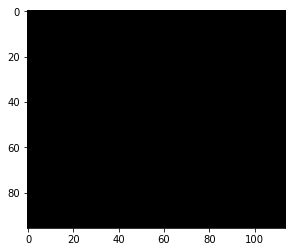

Iteration 158. Loss -189805.734375


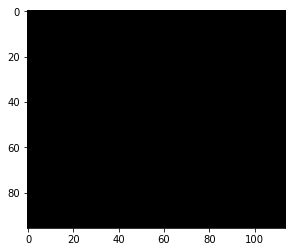

Iteration 159. Loss -197630.5


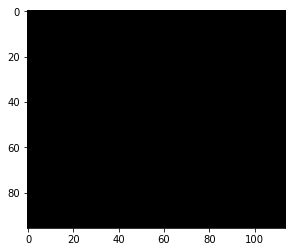

Iteration 160. Loss -188135.203125


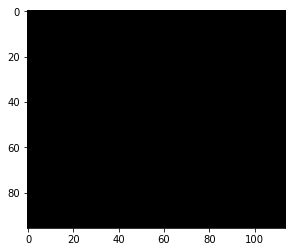

Iteration 161. Loss -176400.65625


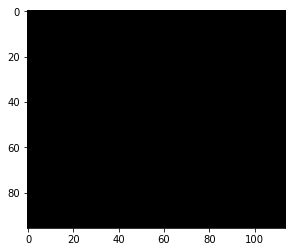

Iteration 162. Loss -167849.921875


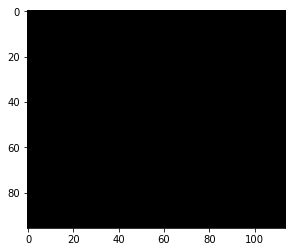

Iteration 163. Loss -162603.96875


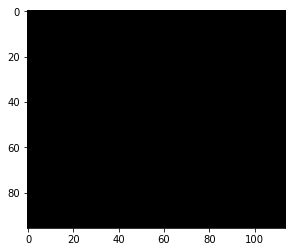

Iteration 164. Loss -161242.53125


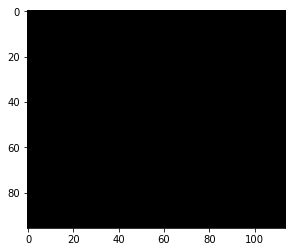

Iteration 165. Loss -172867.859375


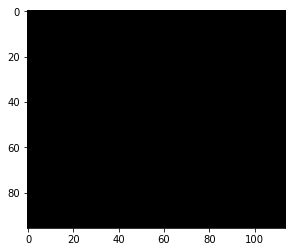

Iteration 166. Loss -177178.828125


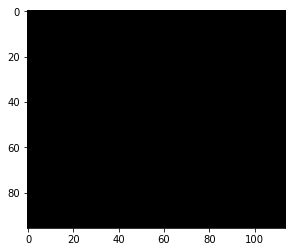

Iteration 167. Loss -167874.234375


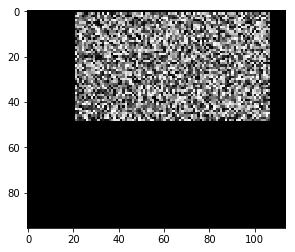

Iteration 168. Loss -171209.453125


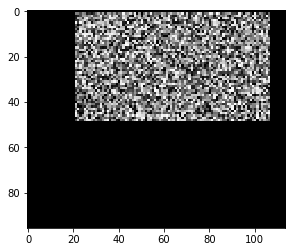

Iteration 169. Loss -171209.453125


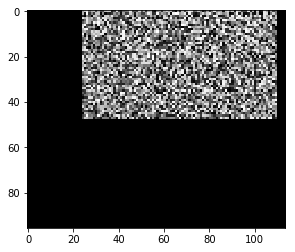

Iteration 170. Loss -166322.0625


Iteration 171. Loss -153178.59375


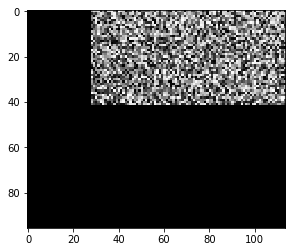

Iteration 172. Loss -138082.359375


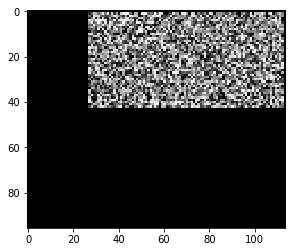

Iteration 173. Loss -142659.890625


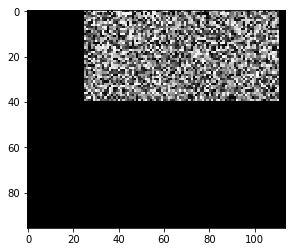

Iteration 174. Loss -137090.125


Iteration 175. Loss -127325.8046875


Iteration 176. Loss -127932.453125


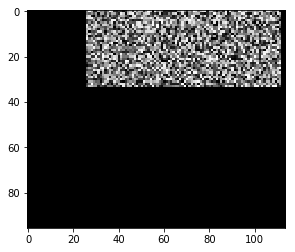

Iteration 177. Loss -115916.5


Iteration 178. Loss -106497.3671875


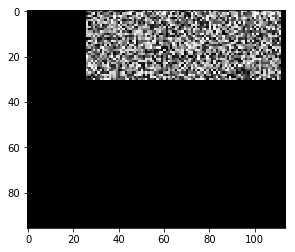

Iteration 179. Loss -106497.375


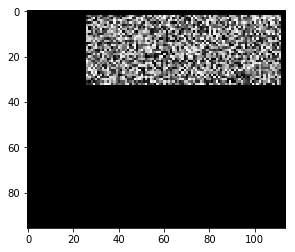

Iteration 180. Loss -112216.5390625


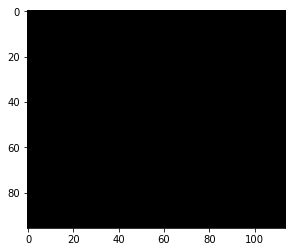

Iteration 181. Loss -113290.390625


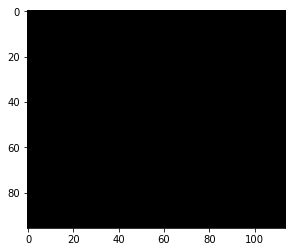

Iteration 182. Loss -105151.3515625


KeyboardInterrupt: 

In [115]:
filter_pos = 1
print("Filter position: {}".format(filter_pos)) 
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True) # input image
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.01)

optimize_activations(sub_model,
                     base,
                     optimizer,
                     filter_pos=filter_pos,
                     num_iters=num_iters,
                     show_x=1,
                     transforms=transf)